In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, precision_recall_curve, roc_curve
import os.path as osp
import xarray as xr
import numpy as np
from sklearn.metrics import roc_auc_score, precision_recall_curve, roc_curve

import _helpers as helpers

### Add helper functions

In [3]:
def read_signature(sig_pth, filter_uniprot = False):
    sig = pd.read_csv(sig_pth, header =None, sep = '\t')
    sig.columns = ['annot','gene']
    
    if filter_uniprot:
        sig = sig.iloc[sig.annot.str.startswith('UniProt').values]
    sig = sig.iloc[:,1].values.tolist()
    
    return sig

In [4]:
OUTPUT_DIR = '/gstore/data/resbioai/andera29/cci-explore/validation/pipeline/data/results_data/bcell'

Load Intergram results

In [5]:
inter_res = xr.load_dataset(osp.join(OUTPUT_DIR,'inter_res.netcdf'))

Extract beta coefficients

In [6]:
beta = inter_res['beta'].to_dataframe().unstack()['beta'].copy()

Get interaction coefficients for the interaction of interst

In [32]:
score = beta.loc['B_naive','T_CD4+_TfH'].copy()
score = np.abs(score)

Define paths to look at

In [33]:
signature_paths = dict(GO_0042110 = 'T cell activation', #negative
                       GO_0042113 = 'B cell activation', # positive
                       GO_0012501 = 'programmed cell death', #negative
                       )

Calculate AUROC for each of the pathways, w.r.t. interaction coefficients

In [34]:
res = dict()
pwy_pth_base=  '../../data/signatures/{}.csv'
for fn, fancy_name in signature_paths.items():
    res[fancy_name] = dict()
    pwy = helpers.read_signature(pwy_pth_base.format(fn), filter_uniprot=True)
    pwy = [x.lower() for x in pwy]
    target = np.array([float(x in pwy) for x in score.index])
    pred = np.abs(score.values)
    
    res[fancy_name]['auroc_curve'] = roc_curve(target, pred)
    res[fancy_name]['auroc_score'] =  roc_auc_score(target, pred)
    res[fancy_name]['pr_curve'] = precision_recall_curve(target, pred)
    res[fancy_name]['genes'] = pwy

Calculate AUROC for each of the pathways, w.r.t. the highly variable genes

In [35]:
hvg = pd.read_csv(osp.join(OUTPUT_DIR,'hvg_B_GC_prePB.csv'),header = 0, index_col = 0)

In [36]:
res_hvg = dict()
for fn, fancy_name in signature_paths.items():
    res_hvg[fancy_name] = dict()
    pwy = read_signature(pwy_pth_base.format(fn), filter_uniprot=True)
    pwy = [x.lower() for x in pwy]
    target = np.array([float(x in pwy) for x in hvg.index])
    pred = hvg['score'].values
    
    res_hvg[fancy_name]['auroc_curve'] = roc_curve(target, pred)
    res_hvg[fancy_name]['auroc_score'] =  roc_auc_score(target, pred)
    res_hvg[fancy_name]['pr_curve'] = precision_recall_curve(target, pred)
    res_hvg[fancy_name]['genes'] = pwy

Plot results

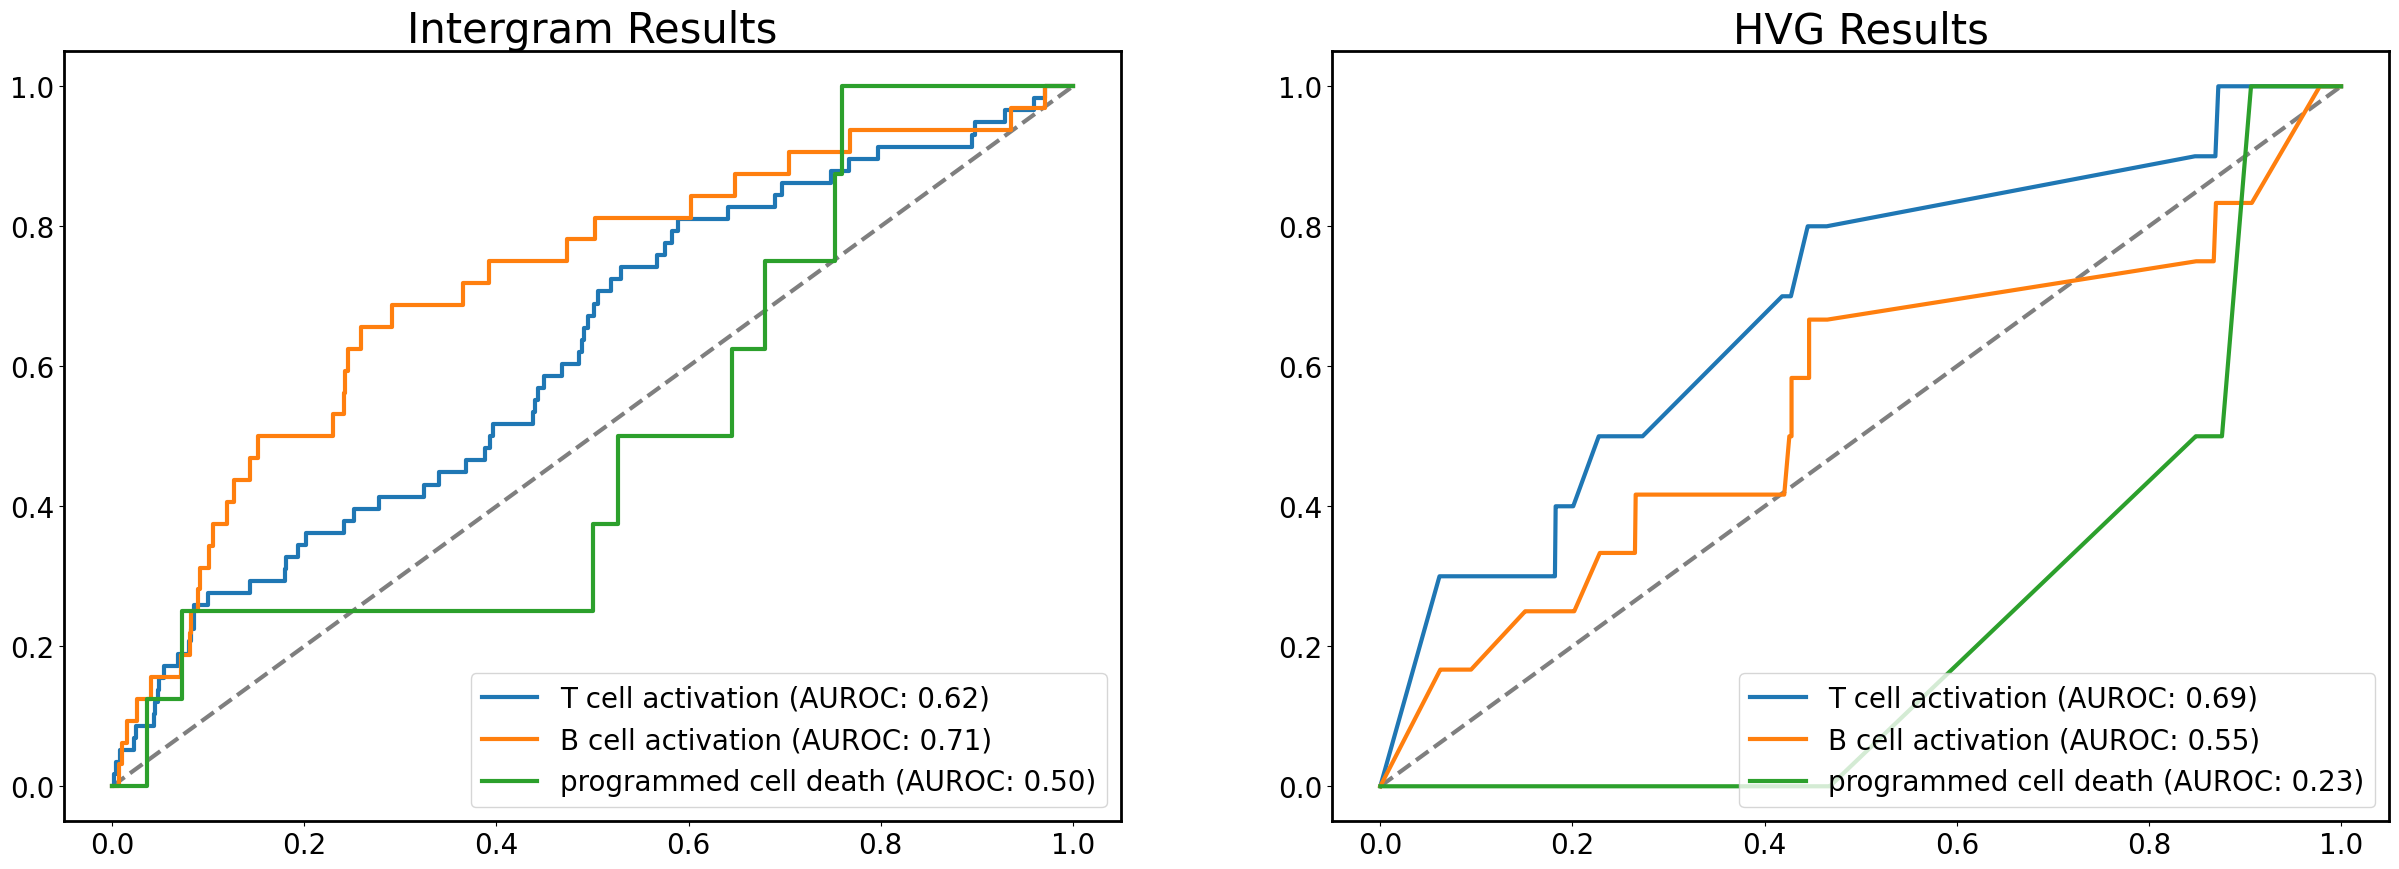

In [37]:
plot_kwargs = dict(linewidth = 3)
lgnd_kwargs = dict(fontsize = 20, loc = 'lower right')
title_kwargs = dict(fontsize = 30)

fig,ax = plt.subplots(1,2, figsize = (30,10))
for k,(name, vals) in enumerate(res.items()):
    ax[0].plot(vals['auroc_curve'][0],vals['auroc_curve'][1], label = f'{name} (AUROC: {vals["auroc_score"]:0.2f})', **plot_kwargs)
    ax[1].plot(res_hvg[name]['auroc_curve'][0],res_hvg[name]['auroc_curve'][1], label = f'{name} (AUROC: {res_hvg[name]["auroc_score"]:0.2f})', **plot_kwargs)

for ii in range(2):
    ax[ii].plot([0,1],[0,1], zorder = -1, color = 'black', linestyle = 'dashed', alpha = 0.5, **plot_kwargs)


ax[0].legend(**lgnd_kwargs)
ax[1].legend(**lgnd_kwargs)
ax[0].set_title('Intergram Results', **title_kwargs)
ax[1].set_title('HVG Results', **title_kwargs)

for axx in ax:

    for sp in axx.spines.values():
       sp.set_linewidth(2)
        
    axx.tick_params(axis='x', labelsize=20, labelrotation=0, labelfontfamily = 'sans-serif')
    axx.tick_params(axis='y', labelsize=20, labelfontfamily = 'sans-serif')